# First Resnet 50 Model

In [2]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
import os
import cv2
import imageio
import skimage
import skimage.io
import skimage.transform
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

In [3]:
#check files in the directory 
os.listdir('./IDC_regular_ps50_idx5/')[:3]

['9036', '10268', '10257']

In [ ]:
#create directory to store images from patients
images = 'images'
os.mkdir(images)

In [ ]:
# received help from https://docs.python.org/3/library/shutil.html and https://www.tutorialspoint.com/python/os_listdir.htm
#create a list for patients 
patient_list = os.listdir('./IDC_regular_ps50_idx5')
for patient in patient_list:
    #create a path variable for positive and negative images
    negative_images = './IDC_regular_ps50_idx5/' + str(patient) + '/0'
    positive_images = './IDC_regular_ps50_idx5/' + str(patient) + '/1'


    # create a list of all files in folders that end in 0
    neg_list = os.listdir(negative_images)
    # create a list of list all files in folders that end in 1
    pos_list = os.listdir(positive_images)
    #shutil.copyfile(src, dst, *, follow_symlinks=True) --- example of format
    #Copy the contents (no metadata) of the file named src to a file named dst and return dst in the most efficient way possible.
    # move the negative images to images
    for filename in neg_list:

        # source path to image
        src = os.path.join(negative_images, filename)
        # destination path to image
        dst = os.path.join(images, filename)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


    # move the positive images to images
    for filename in pos_list:

        # source path to image
        src = os.path.join(positive_images, filename)
        # destination path to image
        dst = os.path.join(images, filename)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
#inspect length of directory
len(os.listdir('images'))

In [5]:
#create a pandas dataframe for images
image_list = os.listdir('images')
df = pd.DataFrame(image_list, columns=['image_id'])
df.head()

,image_id


## Create Dataframe for Images

In [8]:
# append patient ID and target information to df
def get_patient_id(x):
    # split into a list
    a = x.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def get_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the y target 0 or 1 is 5th index of the string --> class1
    target = b[5]
    
    return target

# extract the patient id

# create a new column called 'patient_id' and apply the patient id function 
df['patient_id'] = df['image_id'].apply(get_patient_id)
# create a new column called 'target' and apply the patient's target variable 
df['target'] = df['image_id'].apply(get_target)

df.head(10)

,image_id,patient_id,target
0,10290_idx5_x251_y1101_class0.png,10290,0
1,9228_idx5_x1701_y1851_class0.png,9228,0
2,12901_idx5_x2351_y701_class1.png,12901,1
3,10272_idx5_x3151_y1901_class0.png,10272,0
4,10290_idx5_x151_y1051_class0.png,10290,0
5,12932_idx5_x701_y451_class0.png,12932,0
6,10272_idx5_x1351_y1551_class0.png,10272,0
7,13613_idx5_x2051_y1351_class1.png,13613,1
8,12890_idx5_x1501_y1801_class0.png,12890,0
9,15840_idx5_x251_y851_class0.png,15840,0


In [ ]:
df.shape

In [ ]:
df['target'].value_counts()

In [11]:
#need to ensure there is no class imbalance before modeling the data 
df_0 = df[df['target'] == '0'].sample(78786, random_state=1984)
# take a sample of class 1 (total = 78786)
df_1 = df[df['target'] == '1'].sample(78786, random_state=1984)
# concat dataframes
df = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# Check the new class distribution
df['target'].value_counts()

1    78786
0    78786
Name: target, dtype: int64

## Train / test split 

In [12]:
y = df['target']
df_train, df_val = train_test_split(df, test_size=0.10, random_state=1984)
print(df_train.shape)
print(df_val.shape)

(141814, 3)
(15758, 3)


In [ ]:
df_train['target'].value_counts()

In [ ]:
df_val['target'].value_counts()

In [13]:
# Create a new directory to house the training and validation data 
base_dir = 'base_dir'
os.mkdir(base_dir)
# create a path to 'base_dir' to which we will join the names of the new folders
# train_data
train_data = os.path.join(base_dir, 'train_data')
os.mkdir(train_data)
# val_data
val_data = os.path.join(base_dir, 'val_data')
os.mkdir(val_data)
# Inside each folder we create seperate folders for each class
# create new folders inside train_data
idc_neg = os.path.join(train_data, 'idc_neg')
os.mkdir(idc_neg)
idc_pos = os.path.join(train_data, 'idc_pos')
os.mkdir(idc_pos)
# create new folders inside val_data
idc_neg = os.path.join(val_data, 'idc_neg')
os.mkdir(idc_neg)
idc_pos = os.path.join(val_data, 'idc_pos')
os.mkdir(idc_pos)

In [ ]:
os.listdir('base_dir/train_data')

In [14]:
#setting the image id to be the index of the dataframe
df.set_index('image_id', inplace=True)

In [15]:
# received help from https://docs.python.org/3/library/shutil.html and https://www.tutorialspoint.com/python/os_listdir.htm
# got help from https://www.kaggle.com/paultimothymooney/predict-idc-in-breast-cancer-histology-images 
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
# Transfer the train images
for image in train_list:
    
    
    filename = image
    # set target variable in training list
    target = df.loc[image,'target']
    
    # set these to correct paths 
    if target == '0':
        label = 'idc_neg'
    if target == '1':
        label = 'idc_pos'
    
    # source path to image
    src = os.path.join(images, filename)
    # destination path to image
    dst = os.path.join(train_data, label, filename)
    # move the image from the source to the destination
    shutil.move(src, dst)
    

# Transfer the val images

for image in val_list:
    
    filename = image
    # get the label for a certain image
    target = df.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'idc_neg'
    if target == '1':
        label = 'idc_pos'
    

    # set the source 
    src = os.path.join(images, filename)
    # set path to image
    dst = os.path.join(val_data, label, filename)
    # move the image 
    shutil.move(src, dst)

In [16]:
train_path = 'base_dir/train_data'
valid_path = 'base_dir/val_data'
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [17]:
#Generate batches of tensor image data with real-time data augmentation - https://keras.io/api/preprocessing/image/
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 141814 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.


# Instantiate Resnet50 model 

In [18]:
model = Sequential()

model.add(ResNet50(include_top = False,
                   weights = "imagenet",
                   input_shape=(50,50,3)))
# Dropout
model.add(Dropout(0.5))

# Pooling layer
model.add(GlobalAveragePooling2D())

# Dense layer
model.add(Dense(128, 
                activation = "relu"))

# Batch Normalizer
model.add(BatchNormalization())

# Output layer
model.add(Dense(2, activation = "sigmoid"))

94773248/94765736 [==============================] - 1s 0us/step


In [19]:
early_stop = EarlyStopping(monitor = "val_loss",
                           min_delta = 0,
                           patience = 5)

# Compile model
model.compile(loss = "binary_crossentropy",
              optimizer = Adam(lr = 0.0001),
              metrics = ["accuracy"])

In [20]:
history = model.fit_generator(train_gen, 
                    validation_data = val_gen,
                    callbacks = [early_stop],
                    epochs = 25)

Train for 14182 steps, validate for 1576 steps
Epoch 1/25
14182/14182 [==============================] - 571s 40ms/step - loss: 0.4204 - accuracy: 0.8230 - val_loss: 0.4840 - val_accuracy: 0.8479
Epoch 2/25
14182/14182 [==============================] - 559s 39ms/step - loss: 0.3820 - accuracy: 0.8432 - val_loss: 0.3664 - val_accuracy: 0.8571
Epoch 3/25
14182/14182 [==============================] - 560s 40ms/step - loss: 0.3712 - accuracy: 0.8483 - val_loss: 0.3554 - val_accuracy: 0.8586
Epoch 4/25
14182/14182 [==============================] - 559s 39ms/step - loss: 0.3435 - accuracy: 0.8621 - val_loss: 0.3173 - val_accuracy: 0.8717
Epoch 5/25
14182/14182 [==============================] - 557s 39ms/step - loss: 0.3197 - accuracy: 0.8730 - val_loss: 0.3255 - val_accuracy: 0.8660
Epoch 6/25
14182/14182 [==============================] - 558s 39ms/step - loss: 0.2939 - accuracy: 0.8827 - val_loss: 0.3253 - val_accuracy: 0.8661
Epoch 7/25
14182/14182 [==============================] - 5

In [21]:

# Evaluate model on test data.
scores = model.evaluate_generator(test_gen)
labels = model.metrics_names

# Show model performance
print(f'{labels[0]}: {scores[0]}')
print(f'{labels[1]}: {scores[1]* 100}%')

# Summary of the layers of the model
#model.summary()

loss: 0.35500255470940434
accuracy: 84.60464477539062%


In [22]:

# Predicted classes - Predicted Positives and Predicted Negatives 
predictions = model.predict(test_gen)
pred = predictions[:,1]
predicted_classes = np.argmax(predictions,axis=1)

# True classes - True Positives and True Negatives 
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

In [24]:
# Create report
from sklearn import metrics
report = metrics.classification_report(true_classes, 
                                       predicted_classes,
                                       target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    a_no_idc       0.81      0.90      0.85      7879
   b_has_idc       0.89      0.79      0.84      7879

    accuracy                           0.85     15758
   macro avg       0.85      0.85      0.85     15758
weighted avg       0.85      0.85      0.85     15758



In [ ]:
# Create Confusion Matrix
plt.style.use('seaborn')

cm = metrics.confusion_matrix(true_classes,predicted_classes)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5),
                                class_names = class_labels,
                                show_normed = True)
ax.set(title = "Confusion Matrix for IDC",
       ylabel = "True Labels",
       xlabel = "Predicted Labels")
plt.show()

In [ ]:
train_loss = history.history["accuracy"]
test_loss = history.history["val_accuracy"]
plt.figure(figsize = (9,6))


plt.plot(train_loss, label = "Resnet50 Model Training Accuracy", color = "navy")
plt.plot(test_loss, label = "Resnet50 Model Testing Accuracy" , color= "skyblue")
plt.title("Resnet50 Model", fontsize = 20)
plt.xlabel("Epoch Count", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend();

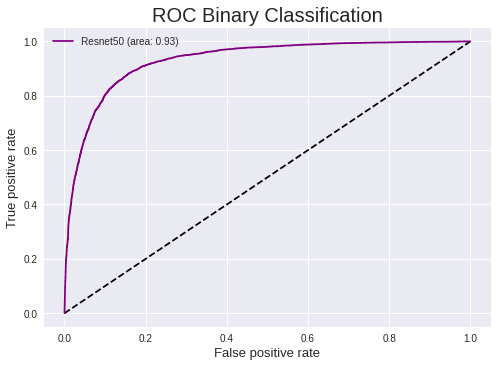

In [28]:
# ROC curve graph for Resnet50
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_classes, pred)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Resnet50 (area: %0.2f)'
             % auc(fpr,tpr), color = "purple")
plt.xlabel('False positive rate', fontsize = 13)
plt.ylabel('True positive rate', fontsize = 13)
plt.title('ROC Binary Classification', fontsize = 20)
plt.legend(loc='best')
plt.show()

In [ ]:
# save weights from this model
model.save_weights("first_resnet50_model.h5")